In [1]:
'''
GCBC with point maze (with multi-goal + color state space)
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define simple MLP
class MLP(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod)
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)
    
def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

In [223]:
# Goal-conditioned Point Maze (with multi state + color)
import gym
import gym.wrappers

class PointEnvComplex(gym.Env):
    def __init__(self):
        self.pos = np.array([0., 0.])
        self.obj1_pos = np.array([1., 1.])
        self.obj1_color = np.array([0.])
        self.obj2_pos = np.array([1., 0.])
        self.obj2_color = np.array([0.])
        self.obj3_pos = np.array([-1., 0.])
        self.obj3_color = np.array([0.])
        self.goal_pos = np.array([-9., -9.])
        self.goal_color = np.array([0.])
        self.max_vel = 1.
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(14), np.inf * np.ones(14)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    def reset(self):
        self.pos = np.zeros(2)
        self.obj1_pos = np.zeros(2)
        self.obj1_color = np.zeros(1)
        self.obj2_pos = np.zeros(2)
        self.obj2_color = np.zeros(1)
        self.obj3_pos = np.zeros(2)
        self.obj3_color = np.zeros(1)
        self.goal_pos = np.zeros(2)
        self.goal_color = np.zeros(1)
        return self.get_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.obj3_pos, self.obj3_color, self.goal_color]))

    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal_pos))
        return self.get_obs(), reward, False, {}
    
    def reward_fn(self, state):
        return -torch.linalg.norm((state - torch.Tensor(self.goal_pos).to(device)), dim=-1)

    def get_color(self, env_value):
        if env_value == 0:
            return 'red'
        elif env_value == 1:
            return 'blue'
        elif env_value == 2:
            return 'green'
        elif env_value == 3:
            return 'yellow'

env1 = PointEnvComplex()

In [224]:
def plot_env(env):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    plt.scatter([env.pos[0]],[env.pos[1]], marker='o', color='black', s=30) # plots agent
    plt.scatter([env.obj1_pos[0]],[env.obj1_pos[1]], marker='s', color=env.get_color(env.obj1_color[0]), s=30) # plots obj1
    plt.scatter([env.obj2_pos[0]],[env.obj2_pos[1]], marker='s', color=env.get_color(env.obj2_color[0]), s=30) # plots obj2
    plt.scatter([env.obj3_pos[0]],[env.obj3_pos[1]], marker='s', color=env.get_color(env.obj3_color[0]), s=30) # plots obj3
    plt.scatter([env.goal_pos[0]],[env.goal_pos[1]], marker='*', color=env.get_color(env.goal_color[0]), s=100) # plots obj3

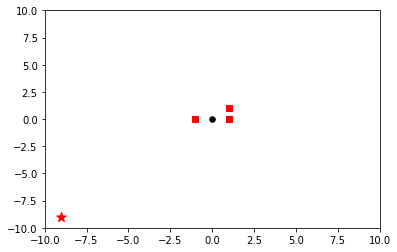

In [225]:
plot_env(env1)

In [226]:
# generates random trajs within specified constraints
def gen_trajs(env, num_trajs=1, obj_angles=2*np.pi, obj_colors=4):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    trajs = []
    for traj in range(num_trajs):
        env.reset()
        # obj1
        angle = np.random.uniform(0, obj_angles) # samples angle in radians (from range)
        pos = np.array([5*np.cos(angle), 5*np.sin(angle)]) # samples random goal pos
        color = np.array(random.randint(0, obj_colors-1)) # samples color from range
        env.obj1_pos = pos
        env.obj1_color = np.reshape(color, 1)
        
        # obj2
        angle = np.random.uniform(0, obj_angles) # samples angle in radians (from range)
        pos = np.array([5*np.cos(angle), 5*np.sin(angle)]) # samples random goal pos
        color = np.array(random.randint(0, obj_colors-1)) # samples color from range
        env.obj2_pos = pos
        env.obj2_color = np.reshape(color, 1)
        
        # obj3
        angle = np.random.uniform(0, obj_angles) # samples angle in radians (from range)
        pos = np.array([5*np.cos(angle), 5*np.sin(angle)]) # samples random goal pos
        color = np.array(random.randint(0, obj_colors-1)) # samples color from range
        env.obj3_pos = pos
        env.obj3_color = np.reshape(color, 1)
        
        # choose goal from random in objects
        goal_obj = random.randint(1, 3)
        if goal_obj == 1:
            goal_pos = env.obj1_pos
            goal_color = env.obj1_color
        elif goal_obj == 2:
            goal_pos = env.obj2_pos
            goal_color = env.obj2_color
        elif goal_obj == 3:
            goal_pos = env.obj3_pos
            goal_color = env.obj3_color
        env.goal_pos = goal_pos
        env.goal_color = goal_color
        
        # rolls out a trajectory towards the goal
        traj = {'obs': [],'acts': [], 'next_obs': []}
        delta_vector = env.goal_pos
        o = env.get_obs()
        for i in range(100):
            act = delta_vector * 0.01 # Go in direction between start and end
            no, r, d, _ = env.step(act)
            traj['obs'].append(o.copy())
            traj['acts'].append(act.copy())
            traj['next_obs'].append(no.copy())
            o = no
        traj['obs'] = np.array(traj['obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['next_obs'] = np.array(traj['next_obs'])
        
        plot_env(env)
        plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
        
        trajs.append(traj)

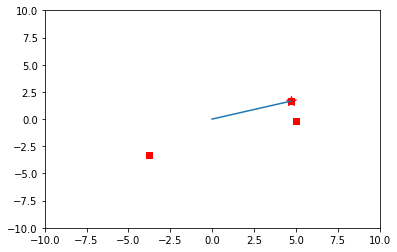

In [257]:
env = PointEnvComplex()
trajs = gen_trajs(env, num_trajs=1, obj_angles=2*np.pi, obj_colors=1)

In [211]:
env.get_obs()

array([-3.75311784, -3.30365048, -1.33032391, -4.81977575,  3.        ,
       -2.44157621,  4.36333653,  1.        , -3.75311784, -3.30365048,
        4.        ,  4.        ])